# Bank Loan Approval Predicting Model Using Random Forest

In [558]:
#import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics 
from sklearn.tree import plot_tree

In [559]:
# read csv file
data = pd.read_csv(r'C:\Users\user\Downloads\archive (3)\credit_risk_dataset.csv')

In [560]:
# view basic information about the data
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [561]:
data.shape

(32581, 12)

In [562]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


# Data Cleaning

In [563]:
#check columns with missing values
data.isnull().any(axis=1).sum()

3943

There are two columns with missing values totalling about 4000. It may not be wise to drop these rows yet. Let us however view the descriptive statistics of the dataset

In [564]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


For the loan_int_rate column, the mean and median is about the same which suggests that the data in the column has a normal distribution. As such we could replace the missing values with the mean value. Another more accurate way to deal with this would be to train a simple regression model to predict loan_int_rate using other available features. Then, use this model to fill in missing loan_int_rate values. For now, let us go with the first option. Same thing would be done to the missing values in person_emp_length	column.

<Axes: >

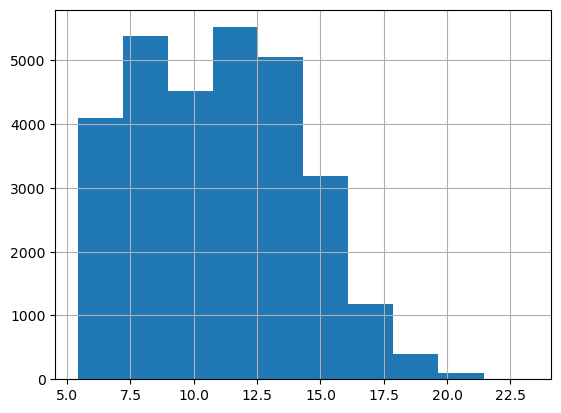

In [565]:
# lets confirm the shape of the distribution
data['loan_int_rate'].hist()

In [566]:
# Data is fairly normal so we can replace the NA with the mean
data['loan_int_rate'].fillna(data['loan_int_rate'].mean(), inplace = True)

<Axes: xlabel='person_emp_length', ylabel='Count'>

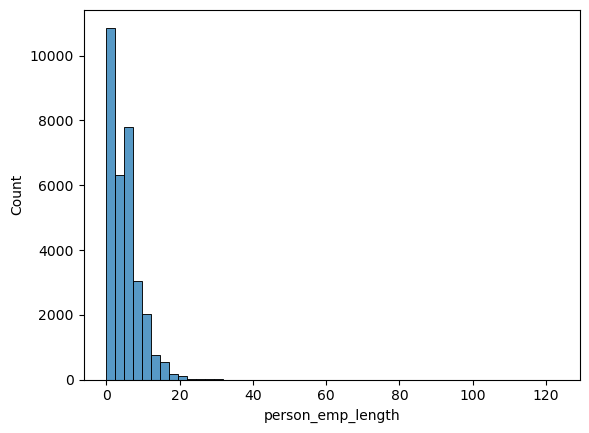

In [567]:
import warnings
warnings.filterwarnings("ignore")
sns.histplot(data['person_emp_length'], bins = 50)

This is right skewed, replacing the NA with mean or median may negatively impact the model, since the missing values is just over 2%, drop rows with NA

In [568]:
data_subset=data.dropna(axis = 0)

In [569]:
#check for duplicates
data_subset[data_subset.duplicated()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.990000,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.360000,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.420000,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.900000,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.880000,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.420000,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.880000,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.990000,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.370000,0,0.03,N,16


In [570]:
#Find the length of duplicates
len(data_subset[data_subset.duplicated()])

157

For now, the duplicates should be removed, although their isn't a unique feature identifier to confirm that these are indeed duplicates entries and not legitimate coincidence

In [571]:
data_subset1=data_subset.drop_duplicates()

In [572]:
#confirm that duplicates have been dropped
data_subset1[data_subset1.duplicated()]


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length


Since RandomForest model uses Boostrapping, it has high insensitivity to outliers, so we will not remove any.

# Check for imbalance

In [573]:
data_subset1['loan_status'].value_counts(normalize=True)

loan_status
0    0.784072
1    0.215928
Name: proportion, dtype: float64

# Check and remove extreme outliers

Random Forest models are robust and have high insensitivity to outliers, it could still be affect by extreme outliers. Check for outliers using a boxplot and create a function to remove any

<Axes: ylabel='person_age'>

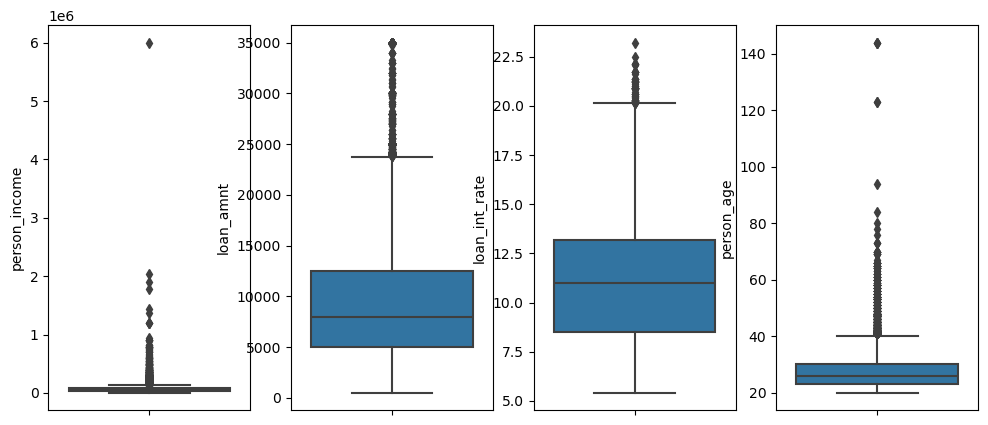

In [574]:
fig, ax = plt.subplots(1,4, figsize=(12,5))
sns.boxplot(data=data_subset1, y='person_income', ax=ax[0])
sns.boxplot(data=data_subset1, y='loan_amnt',  ax=ax[1])
sns.boxplot(data=data_subset1, y='loan_int_rate',  ax=ax[2])
sns.boxplot(data=data_subset1, y='person_age',  ax=ax[3])

The boxplot above is a confirmation that some the features have extreme outliers,

In [575]:
# write a function to cap extreme outliers only.
def outlier_threshold(x):
    q1=x.quantile(0.25)
    q3= x.quantile(0.75)
    iqr= q3-q1
    upper_limit = q3 + 6 * iqr
    capped = [upper_limit if i > upper_limit else i for i in x]
    return capped
    

In [576]:
data_subset1['person_income'] = outlier_threshold(data_subset1['person_income'])
data_subset1['loan_amnt'] = outlier_threshold(data_subset1['loan_amnt'])
data_subset1['person_age'] = outlier_threshold(data_subset1['person_age'])
data_subset1['loan_int_rate'] = outlier_threshold(data_subset1['loan_int_rate'])
data_subset1['person_emp_length'] = outlier_threshold(data_subset1['person_emp_length'])

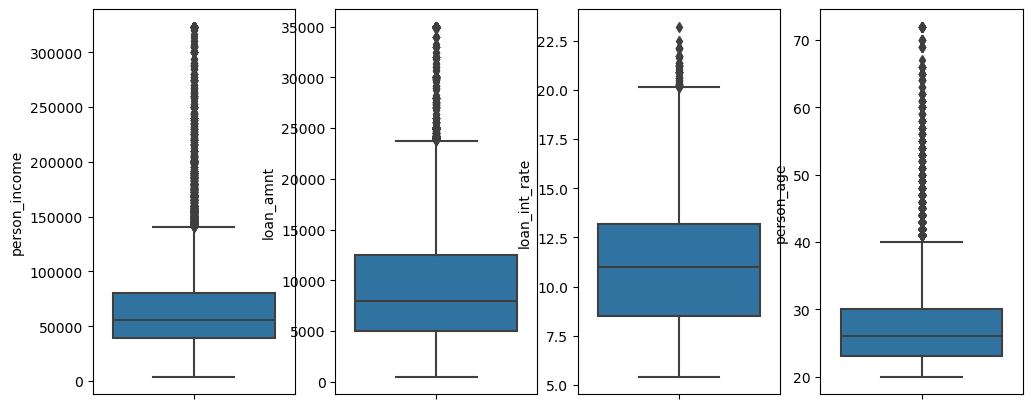

In [577]:
#confirm that extreme outliers were capped 
fig, ax = plt.subplots(1,4, figsize=(12,5))
sns.boxplot(data=data_subset1, y='person_income', ax=ax[0])
sns.boxplot(data=data_subset1, y='loan_amnt',  ax=ax[1])
sns.boxplot(data=data_subset1, y='loan_int_rate',  ax=ax[2])
sns.boxplot(data=data_subset1, y='person_age',  ax=ax[3])
plt.show()

# Data Visualization

Use plots to show the relationship between features

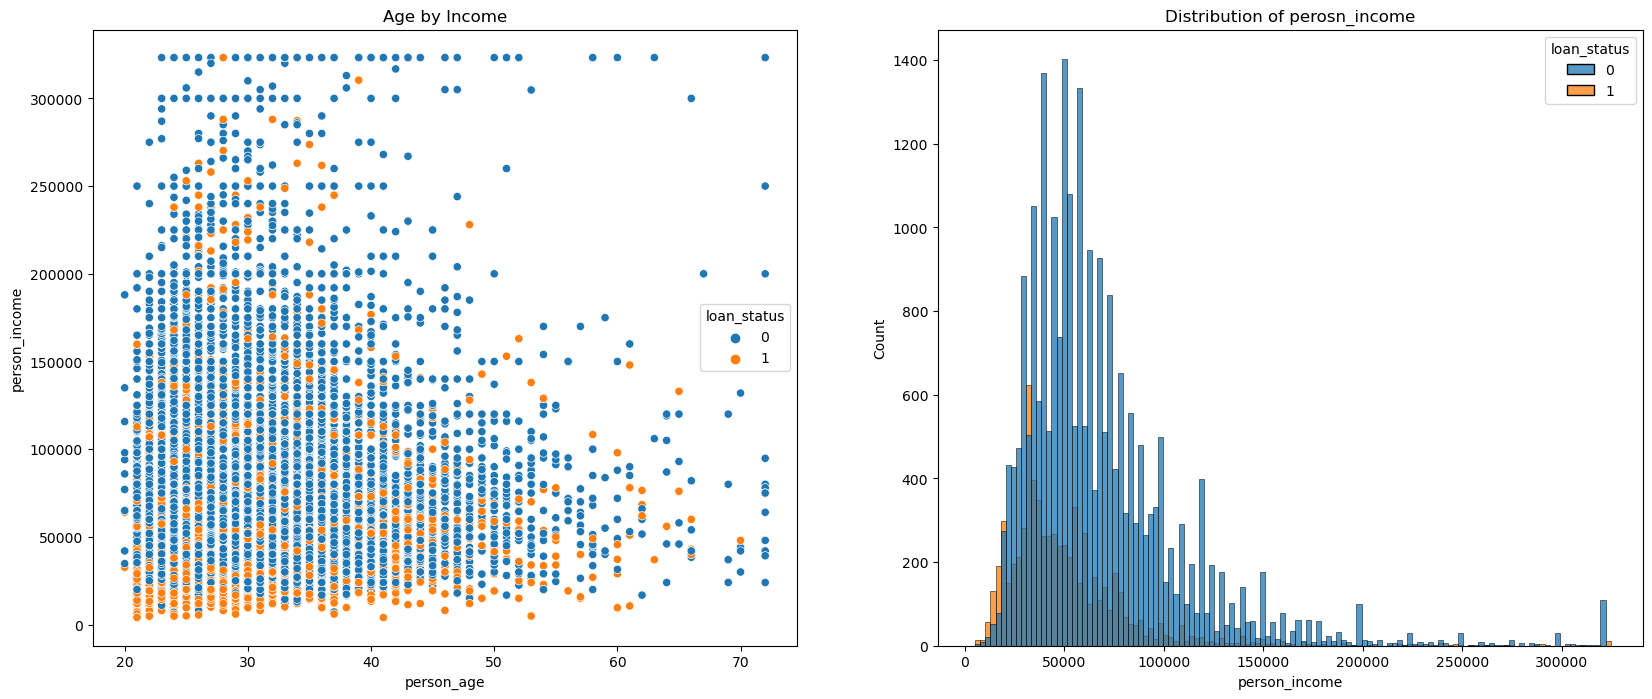

In [578]:
#use boxplot to visualise the relationship between person_age and income with respect to those loan_status
fig, ax = plt.subplots(1,2, figsize = (20,8))
sns.scatterplot(data=data_subset1, x = 'person_age', y='person_income', hue = 'loan_status', ax=ax[0])
ax[0].set_title('Age by Income')
sns.histplot(data=data_subset1, x = 'person_income', hue = 'loan_status', multiple='dodge', shrink=2, ax=ax[1] )
ax[1].set_title('Distribution of perosn_income')
plt.show()

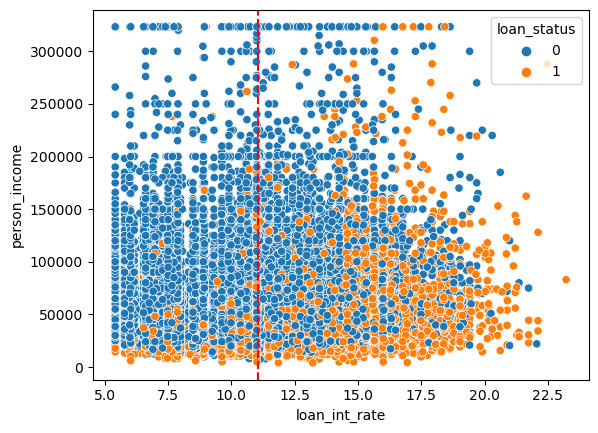

In [579]:
#chart to show the interaction between 'loan_int_rate' and 'person_income',
sns.scatterplot(data=data_subset1, x = 'loan_int_rate', y='person_income', hue = 'loan_status')
plt.axvline(x=data_subset1['loan_int_rate'].mean(), color = 'r', linestyle = '--')

* This visualization confirms that more loans were approved for low income earners irrespective of the interest rate.
* Secondly more loans got approved as the interest rate increased. Particularly, interest rates above the average interest rate of about 11% appear way more likely to be approved

In [580]:
#check descriptive statistics of current dataset
data_subset1.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,31529.000000,31529.000000,31529.000000,31529.000000,31529.000000,31529.000000,31529.000000,31529.000000
mean,27.747407,65566.554696,4.784896,9665.152717,11.042149,0.215928,0.169660,5.816201
std,6.228868,41024.204870,4.043970,6336.661842,3.071705,0.411471,0.106324,4.064782
min,20.000000,4000.000000,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,39456.000000,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,56000.000000,4.000000,8000.000000,11.011695,0.000000,0.150000,4.000000
75%,30.000000,80000.000000,7.000000,12500.000000,13.160000,0.000000,0.230000,8.000000
max,72.000000,323264.000000,37.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Feature Engineering

Feature transformation and feature extraction would be carried out on multiple columns however before building the model, however, feature selection will be done by choosing the most important features from feature_importance

In [581]:
# group age into four categories to reduce noise in the dataset
age_bins = [0,30,50,65,80]
age_label =['young', 'middle age', 'senior', 'elderly']
data_subset1['age_group'] = pd.cut(data_subset1['person_age'], bins= age_bins, labels= age_label)
data_subset1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_group
0,22.0,59000.0,RENT,37.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,young
1,21.0,9600.0,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,young
2,25.0,9600.0,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,young
3,23.0,65500.0,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,young
4,24.0,54400.0,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,young


In [582]:
# create categorical levels for income
income_bins = [0, 35000, 75000, 100000, 500000]
income_label = ['LOW', 'MEDIUM', 'UPPER', 'HIGH']
data_subset1['income_level']=pd.cut(data_subset1['person_income'], bins = income_bins, labels= income_label)

In [583]:
#engineer an interaction between income_level and home ownership
data_subset1['income_homeownership'] = data_subset1['income_level'].astype(str) + '_' + data_subset1['person_home_ownership']

In [584]:
data_subset1.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_group,income_level,income_homeownership
0,22.0,59000.0,RENT,37.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,young,MEDIUM,MEDIUM_RENT
1,21.0,9600.0,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,young,LOW,LOW_OWN
2,25.0,9600.0,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,young,LOW,LOW_MORTGAGE
3,23.0,65500.0,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,young,MEDIUM,MEDIUM_RENT
4,24.0,54400.0,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,young,MEDIUM,MEDIUM_RENT


In [585]:
#transforms the loan_percent_income feature to ensure it is consistent with capped outliers
data_subset1['loan_percent_income'] = data_subset1['loan_amnt'] / data_subset1['person_income']

In [586]:
#The loan_grade categorises the risk assigned to a loan, as such it is ordinal and should be converted to digits
data_subset1['loan_grade'].unique()

array(['D', 'B', 'C', 'A', 'E', 'F', 'G'], dtype=object)

In [587]:
# convert the ordinal grading to represent numeric values
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data_subset1['loan_grade']=data_subset1['loan_grade'].map(grade_mapping)
data_subset1.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_group,income_level,income_homeownership
0,22.0,59000.0,RENT,37.0,PERSONAL,4,35000,16.02,1,0.593220,Y,3,young,MEDIUM,MEDIUM_RENT
1,21.0,9600.0,OWN,5.0,EDUCATION,2,1000,11.14,0,0.104167,N,2,young,LOW,LOW_OWN
2,25.0,9600.0,MORTGAGE,1.0,MEDICAL,3,5500,12.87,1,0.572917,N,3,young,LOW,LOW_MORTGAGE
3,23.0,65500.0,RENT,4.0,MEDICAL,3,35000,15.23,1,0.534351,N,2,young,MEDIUM,MEDIUM_RENT
4,24.0,54400.0,RENT,8.0,MEDICAL,3,35000,14.27,1,0.643382,Y,4,young,MEDIUM,MEDIUM_RENT


#### create an interaction between  features that describes the risk to create a composite risk score for each applicant


In [588]:
# write a function to create a risk category based on the composite risk score and of applicant
def risk_category(df):
    '''This function uses loan_grade as the principal risk accessor along with with other columns such as 
        loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length to create a composite 
        risk score for each row. This risk score is then categorised into LOW, MEDIUM and HIGH'''
    score = 0
    #Adjust score based on loan_grade
    score += df['loan_grade']
    
    #Adjust score based on loan_percent_income
    if df['loan_percent_income'] > 0.3:
        score += 3 # High risk
    
    elif df['loan_percent_income'] > 0.15:
        score += 2 # Medium risk
        
    else:
        score += 1 # Low risk
    
    #Adjust score based on cb_person_cred_hist_length
    if df['cb_person_cred_hist_length'] < 4:
        score += 3 # High risk for short credit history
    elif df['cb_person_cred_hist_length'] < 8:
        score += 2 # Medium risk credit history
    else:
        score +=1 # Low risk for long credit history
        
    #Adjust score based on cb_person_default_on_file
    if df['cb_person_default_on_file'].upper() == 'Y':
        score += 3 # Penalise for previos loan default
        
    #create risk categories based on composite score
    if score <= 6:
        return 0 #This represents low risk
    
    elif score <= 10:
        return 1 # This represent Medium risk
    
    else:
        return 2 #This represents high risk
    


In [589]:
# apply function
data_subset1['risk_category'] =data_subset1.apply(risk_category, axis=1)

In [590]:
data_subset1.head(5)
#data_subset1.info(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_group,income_level,income_homeownership,risk_category
0,22.0,59000.0,RENT,37.0,PERSONAL,4,35000,16.02,1,0.593220,Y,3,young,MEDIUM,MEDIUM_RENT,2
1,21.0,9600.0,OWN,5.0,EDUCATION,2,1000,11.14,0,0.104167,N,2,young,LOW,LOW_OWN,0
2,25.0,9600.0,MORTGAGE,1.0,MEDICAL,3,5500,12.87,1,0.572917,N,3,young,LOW,LOW_MORTGAGE,1
3,23.0,65500.0,RENT,4.0,MEDICAL,3,35000,15.23,1,0.534351,N,2,young,MEDIUM,MEDIUM_RENT,1
4,24.0,54400.0,RENT,8.0,MEDICAL,3,35000,14.27,1,0.643382,Y,4,young,MEDIUM,MEDIUM_RENT,2


In [591]:
# cat encode ordinal variables such as age_group and income level
data_subset_encode = data_subset1.copy()
data_subset_encode['age_group'] = data_subset_encode['age_group'].astype('category').cat.set_categories(age_label).cat.codes
data_subset_encode['income_level'] = \
data_subset_encode['income_level'].astype('category').cat.set_categories(income_label).cat.codes
data_subset_encode.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_group,income_level,income_homeownership,risk_category
0,22.0,59000.0,RENT,37.0,PERSONAL,4,35000,16.02,1,0.593220,Y,3,0,1,MEDIUM_RENT,2
1,21.0,9600.0,OWN,5.0,EDUCATION,2,1000,11.14,0,0.104167,N,2,0,0,LOW_OWN,0
2,25.0,9600.0,MORTGAGE,1.0,MEDICAL,3,5500,12.87,1,0.572917,N,3,0,0,LOW_MORTGAGE,1
3,23.0,65500.0,RENT,4.0,MEDICAL,3,35000,15.23,1,0.534351,N,2,0,1,MEDIUM_RENT,1
4,24.0,54400.0,RENT,8.0,MEDICAL,3,35000,14.27,1,0.643382,Y,4,0,1,MEDIUM_RENT,2


In [592]:
#dummy encode categorical variables

data_subset_encode2 = pd.get_dummies(data_subset_encode, drop_first = False)
data_subset_encode2.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,age_group,...,income_homeownership_LOW_OWN,income_homeownership_LOW_RENT,income_homeownership_MEDIUM_MORTGAGE,income_homeownership_MEDIUM_OTHER,income_homeownership_MEDIUM_OWN,income_homeownership_MEDIUM_RENT,income_homeownership_UPPER_MORTGAGE,income_homeownership_UPPER_OTHER,income_homeownership_UPPER_OWN,income_homeownership_UPPER_RENT
0,22.0,59000.0,37.0,4,35000,16.02,1,0.593220,3,0,...,False,False,False,False,False,True,False,False,False,False
1,21.0,9600.0,5.0,2,1000,11.14,0,0.104167,2,0,...,True,False,False,False,False,False,False,False,False,False
2,25.0,9600.0,1.0,3,5500,12.87,1,0.572917,3,0,...,False,False,False,False,False,False,False,False,False,False
3,23.0,65500.0,4.0,3,35000,15.23,1,0.534351,2,0,...,False,False,False,False,False,True,False,False,False,False
4,24.0,54400.0,8.0,3,35000,14.27,1,0.643382,4,0,...,False,False,False,False,False,True,False,False,False,False


In [593]:
# dummied columns were displayed in bool dtype, it should be converted to int
boolean_columns = data_subset_encode2.select_dtypes(include='bool').columns

# Convert boolean columns to integers
data_subset_encode2[boolean_columns] = data_subset_encode2[boolean_columns].astype(int)
data_subset_encode2.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,age_group,...,income_homeownership_LOW_OWN,income_homeownership_LOW_RENT,income_homeownership_MEDIUM_MORTGAGE,income_homeownership_MEDIUM_OTHER,income_homeownership_MEDIUM_OWN,income_homeownership_MEDIUM_RENT,income_homeownership_UPPER_MORTGAGE,income_homeownership_UPPER_OTHER,income_homeownership_UPPER_OWN,income_homeownership_UPPER_RENT
0,22.0,59000.0,37.0,4,35000,16.02,1,0.593220,3,0,...,0,0,0,0,0,1,0,0,0,0
1,21.0,9600.0,5.0,2,1000,11.14,0,0.104167,2,0,...,1,0,0,0,0,0,0,0,0,0
2,25.0,9600.0,1.0,3,5500,12.87,1,0.572917,3,0,...,0,0,0,0,0,0,0,0,0,0
3,23.0,65500.0,4.0,3,35000,15.23,1,0.534351,2,0,...,0,0,0,0,0,1,0,0,0,0
4,24.0,54400.0,8.0,3,35000,14.27,1,0.643382,4,0,...,0,0,0,0,0,1,0,0,0,0


# Model Building

In [594]:
# create Outcome variable
y = data_subset_encode2['loan_status']

In [595]:
# create dependent features
X = data_subset_encode2.drop('loan_status', axis = 1)


In [596]:
#split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0, stratify = y)

In [597]:
# instantiate the random forest model
#rf= RandomForestClassifier(random_state = 0)

In [598]:
#assign a dictionary to hold hyperparameter values to search over
#cv_params = {
           # 'n_estimators': [250,300,350],
           # 'min_samples_leaf': [1,3],
           # 'max_features':['sqrt'],
           # 'max_depth': [35, 40],
           # 'min_samples_split': [15,18]
            
           # }
#scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}
#grd_rf = GridSearchCV(estimator=rf, param_grid=cv_params, scoring =scoring, refit = 'f1', cv=5, verbose = 2, n_jobs = -1)

In [599]:
#%%time
#grd_rf.fit(X_train, y_train)

In [600]:
import pickle
#with open('C:/Users/user/OneDrive/Documents/Models/grd_rf.pickle', 'wb') as to_write:
    #pickle.dump(grd_rf, to_write)
 

In [601]:
with open('C:/Users/user/OneDrive/Documents/Models/grd_rf.pickle', 'rb') as to_read:
    grd_rf_loader = pickle.load(to_read)

In [602]:
print(hasattr(grd_rf_loader, 'cv_results_')) 

True


In [603]:
print("Best parameters found: ", grd_rf.best_params_)
print("Best F1 score: ", grd_rf.best_score_)


Best parameters found:  {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 350}
Best F1 score:  0.822773233387631


In [604]:
# get the value of all cross-validation in dataframe
cv_result = pd.DataFrame(grd_rf.cv_results_)

#isolate row with maximun (F1 score)
best_estimator_result = cv_result.iloc[cv_result['mean_test_f1'].idxmax(),:]

 # Extract accuracy, precision, recall, and f1 score from that row
f1 = best_estimator_result.mean_test_f1
recall = best_estimator_result.mean_test_recall
precision = best_estimator_result.mean_test_precision
accuracy = best_estimator_result.mean_test_f1

# Create table of results
train_result = pd.DataFrame({'Model': 'Random Forest CV',
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
train_result

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.822773,0.717978,0.963466,0.822773


This model shows a strong precision of 96.35%, indicating its effectiveness in predicting loan approvals. However, recall is lower at 71.80%, meaning the model misses some potential loan approvals. This suggests a trade-off between precision and recall, where the model is cautious in approving loans but may overlook some eligible applicants

In [605]:
#Test performance on test data
y_pred = grd_rf.best_estimator_.predict(X_test)

In [606]:
# Generate scoring metric on test data
f1_test = metrics.f1_score(y_test, y_pred)
recall_test = metrics.recall_score(y_test, y_pred)
precision_test = metrics.precision_score(y_test, y_pred)
accuracy_test = metrics.accuracy_score(y_test, y_pred)

In [607]:
 test_result = pd.DataFrame({'Model': 'Random Forest Test',
                          'F1': [f1_test],
                          'Recall': [recall_test],
                          'Precision': [precision_test],
                          'Accuracy': [accuracy_test]
                         }
                        )
 test_result

,Model,F1,Recall,Precision,Accuracy
0,Random Forest Test,0.80727,0.691539,0.969522,0.928707


The model’s performance on the test set is also strong, with a high precision of 96.95%. While the recall decreases slightly to 69.15%, the overall accuracy of 92.87% demonstrates that the model generalizes well to unseen data, accurately predicting both loan approvals and rejections.

In [608]:
#merge results
merged_results = pd.concat([train_result, test_result], axis = 0)
merged_results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.822773,0.717978,0.963466,0.822773
0,Random Forest Test,0.807270,0.691539,0.969522,0.928707


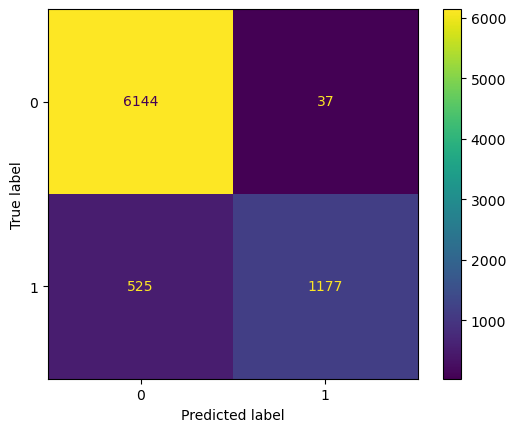

In [612]:
#generate values for confusion matrix 
cm = metrics.confusion_matrix(y_test, y_pred, labels = grd_rf.classes_)

#Display Cvonfusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels =grd_rf.classes_)
disp.plot(values_format = '');


This confusion matrix highlights that the model is highly effective in predicting loan rejections (high TN), and approval (TP), with very few false positives (FP). However, there is a notable number of false negatives (FN), where eligible applicants are incorrectly rejected. This further aligns with the recall metric of 69.15%, showing that the model could benefit from improvements in detecting all eligible loan applicants.

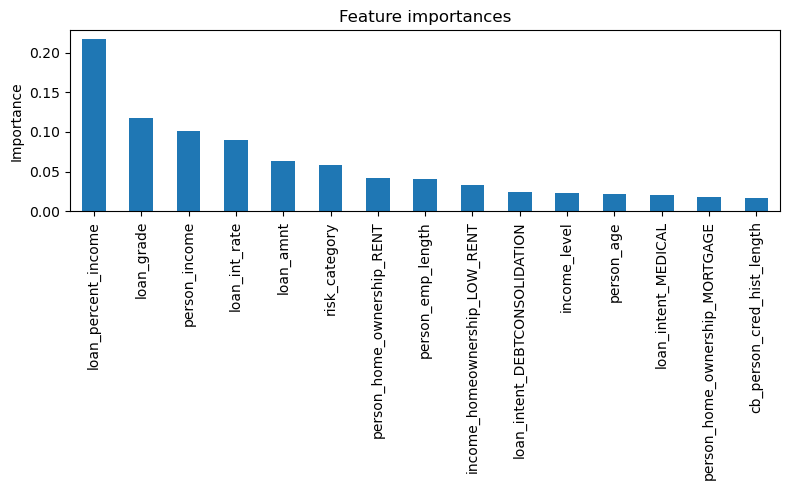

In [610]:
# Plot feature importance charts
importance = grd_rf.best_estimator_.feature_importances_
grd_rf_importance = pd.Series(importance, index = X_test.columns)
grd_rf_importance= grd_rf_importance.sort_values(ascending = False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
grd_rf_importance.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Importance')
fig.tight_layout();


The most influential feature is loan_percent_income, with an importance score of 0.217285, suggesting that the ratio of the loan amount to income plays a major role in determining the likelihood of loan approval. It is followed by loan_grade and person_income.
Features like loan_int_rate and loan_amnt also contribute significantly, while others, such as cb_person_cred_hist_length, have a lesser impact.

# RECOMMENDATION

The loan approval model developed using Random Forest is a robust tool that can help financial institutions minimize potential losses from loan defaults while improving the efficiency and accuracy of loan approval decisions. Based on the findings and evaluation metrics, the following recommendations are provided:

1. This model is recommended for financial institutions aiming to streamline their loan approval processes while reducing the risks associated with defaults. With high precision and accuracy, the model ensures that only eligible applicants are approved for loans, thus safeguarding the institution’s financial interests.


2. The high precision value (96.35% on the training data) indicates that the model is highly effective at correctly classifying applicants who are less likely to default. Financial institutions can rely on the model to approve loans with a lower likelihood of non-repayment, minimizing potential financial losses.


3. While precision is crucial for minimizing risk, improving recall is equally important to ensure that deserving applicants are not excluded. Increasing recall will help capture more potential customers, especially those with a high likelihood of repaying their loans but may fall under certain risk categories that are currently being missed by the model. Techniques such as adjusting decision thresholds, resampling, and cost-sensitive learning can help improve recall without significantly sacrificing precision.


4. It is important to continuously monitor the fairness of the model, especially with respect to different demographic groups. Bias in the approval process can lead to unequal opportunities for loan applicants based on factors such as income, age, or ethnicity. Regular audits, fairness constraints, and bias mitigation techniques should be integrated into the model to ensure equitable loan approval decisions.


5. To maintain the relevance and accuracy of the model over time, periodic retraining with updated data is necessary. Economic conditions, borrower behavior, and loan default patterns can change, and the model must adapt to these shifts to remain effective. Regular updates will ensure that the model continues to perform optimally in the face of evolving trends.


6. The feature importance results indicate that attributes such as "loan_percent_income," "loan_grade," and "person_income" play significant roles in the model’s decision-making process. Institutions can use this insight to further refine their loan policies, focusing on high-impact factors that have a substantial influence on the likelihood of loan repayment.


7. Once optimized, this model can be deployed in real-time loan approval systems, offering an automated and reliable mechanism for assessing applicants. Financial institutions can integrate this model into their existing infrastructure to speed up loan processing times while ensuring accurate risk assessments.

# CONCLUSION

This loan approval model, with its strong performance metrics, is a valuable tool for financial institutions looking to improve loan approval efficiency and reduce defaults. By continuing to fine-tune the model, ensuring fairness, and leveraging insights from the feature importance, the model can become an essential part of a financial institution’s decision-making process.